## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [25]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
sns.set_theme(style='darkgrid')

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [26]:
# (re-)load layers
%run not_my_modules.ipynb
#%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

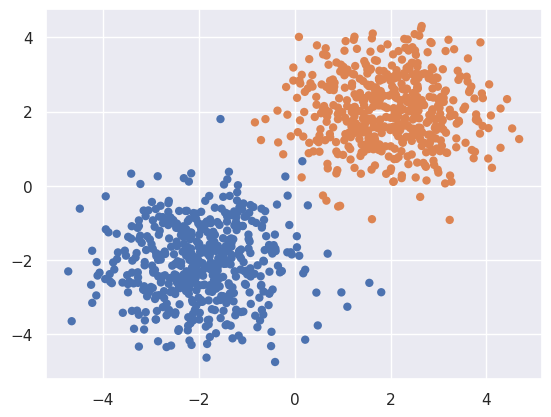

In [27]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c=[sns.color_palette()[int(i)] for i in Y[:,0]],
            edgecolors= 'none')
plt.show()

Define a **logistic regression** for debugging. 

In [28]:
# net = Sequential()
# net.add(Linear(2, 2))
# net.add(LogSoftMax())

# Test something like that then 

net = Sequential(modules = [
            Linear(2, 4),
            BatchNormalization(),
            ChannelwiseScaling(4),
            LeakyReLU(),
            Linear(4, 2),
            LogSoftMax()])

criterion = ClassNLLCriterion()
print(net)

Linear 2 -> 4
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [29]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [30]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

Epoch 0/19
Current loss: 0.582043
----------
Epoch 1/19
Current loss: 0.265823
----------
Epoch 2/19
Current loss: 0.064507
----------
Epoch 3/19
Current loss: 0.023988
----------
Epoch 4/19
Current loss: 0.015046
----------
Epoch 5/19
Current loss: 0.014541
----------
Epoch 6/19
Current loss: 0.006834
----------
Epoch 7/19
Current loss: 0.037163
----------
Epoch 8/19
Current loss: 0.015375
----------
Epoch 9/19
Current loss: 0.024428
----------
Epoch 10/19
Current loss: 0.038515
----------
Epoch 11/19
Current loss: 0.008276
----------
Epoch 12/19
Current loss: 0.003993
----------
Epoch 13/19
Current loss: 0.007110
----------
Epoch 14/19
Current loss: 0.011236
----------
Epoch 15/19
Current loss: 0.056614
----------
Epoch 16/19
Current loss: 0.013504
----------
Epoch 17/19
Current loss: 0.006475
----------
Epoch 18/19
Current loss: 0.039947
----------
Epoch 19/19
Current loss: 0.009087
----------


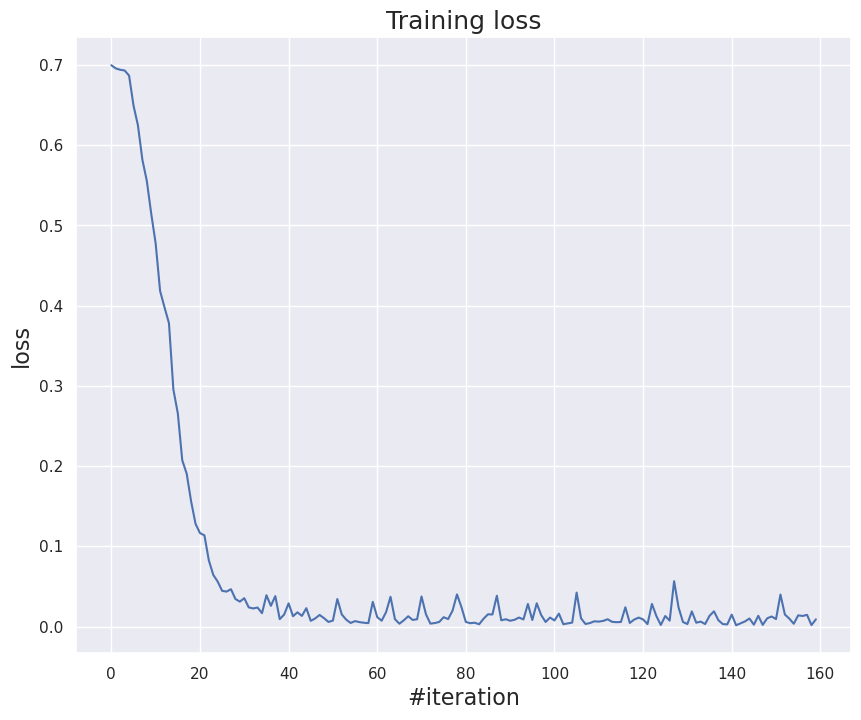

In [31]:
loss_history = []

for i in range(n_epoch):
    
    print(f'Epoch {i}/{n_epoch - 1}')
    
    
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    #display.clear_output(wait=True)
    
    print('Current loss: %f' % loss)
    print('-' * 10)
    
plt.figure(figsize=(10, 8))
plt.title("Training loss", fontsize=18)
plt.xlabel("#iteration", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.plot(loss_history, color=sns.color_palette()[0])
plt.show()

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [32]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [33]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [34]:
net_ReLU = Sequential(modules = [
                    Flatten(),
                    Linear(784, 32),
                    BatchNormalization(),
                    ChannelwiseScaling(32),
                    ReLU(),
                    Linear(32, 10),
                    LogSoftMax()])

net_LeakyReLU = Sequential(modules = [
                    Flatten(),
                    Linear(784, 32),
                    BatchNormalization(),
                    ChannelwiseScaling(32),
                    LeakyReLU(0.03),
                    Linear(32, 10),
                    LogSoftMax()])

net_ELU = Sequential(modules = [
                    Flatten(),
                    Linear(784, 32),
                    BatchNormalization(),
                    ChannelwiseScaling(32),
                    ELU(),
                    Linear(32, 10),
                    LogSoftMax()])

net_SoftPlus = Sequential(modules = [
                    Flatten(),
                    Linear(784, 32),
                    BatchNormalization(),
                    ChannelwiseScaling(32),
                    ELU(),
                    Linear(32, 10),
                    LogSoftMax()])

batch_size = 128
criterion = ClassNLLCriterion()
n_epoch = 20

optimizer_config_ = [{'learning_rate' : 1e-2, 'momentum': 0.9}, 
                     {'learning_rate' : 1e-2, 'momentum': 0.9},
                     {'learning_rate' : 1e-2, 'momentum': 0.9},
                     {'learning_rate' : 1e-2, 'momentum': 0.9}]
optimizer_state_ = [{},{},{},{}]

def compute_accuracy(model, X_test, y_test, cuda=False, Torch=False):
    if Torch:
        model.eval()
    else:
        model.evaluate() 
    total_samples = 0
    correct_samples = 0
    for x, y in get_batches((X_test, y_test), batch_size):
        if Torch:
            if cuda:
                x, y = tensor(x).unsqueeze(1).cuda(), tensor(y).unsqueeze(1).cuda()
            else:
                x, y = tensor(x).unsqueeze(1), tensor(y).unsqueeze(1)
        
        predictions = model.forward(x)
        total_samples += y.shape[0]
        correct_samples += (predictions.argmax(axis=1) == y.argmax(axis=1)).sum()
    
    accuracy = correct_samples / total_samples
    return accuracy

Epoch 1/20
ReLU:
 Loss: 0.9795320459180278, Train acc: 0.75848, Val acc: 0.9172
LeakyReLU:
 Loss: 0.9583858974035016, Train acc: 0.76718, Val acc: 0.9225
ELU:
 Loss: 0.8356435675214648, Train acc: 0.80082, Val acc: 0.919
SoftPlus:
 Loss: 0.8225627387465514, Train acc: 0.80506, Val acc: 0.9198
--------------------------------------------------
Epoch 2/20
ReLU:
 Loss: 0.29728666995396147, Train acc: 0.91592, Val acc: 0.9293
LeakyReLU:
 Loss: 0.2932445639982945, Train acc: 0.91796, Val acc: 0.9307
ELU:
 Loss: 0.3015867481676755, Train acc: 0.91518, Val acc: 0.9269
SoftPlus:
 Loss: 0.3004486750123175, Train acc: 0.91616, Val acc: 0.9287
--------------------------------------------------
Epoch 3/20
ReLU:
 Loss: 0.24261309280926666, Train acc: 0.93076, Val acc: 0.9329
LeakyReLU:
 Loss: 0.23998657433201434, Train acc: 0.93084, Val acc: 0.9336
ELU:
 Loss: 0.2512307847319601, Train acc: 0.9281, Val acc: 0.9298
SoftPlus:
 Loss: 0.24815944334222265, Train acc: 0.92958, Val acc: 0.9327
-----------

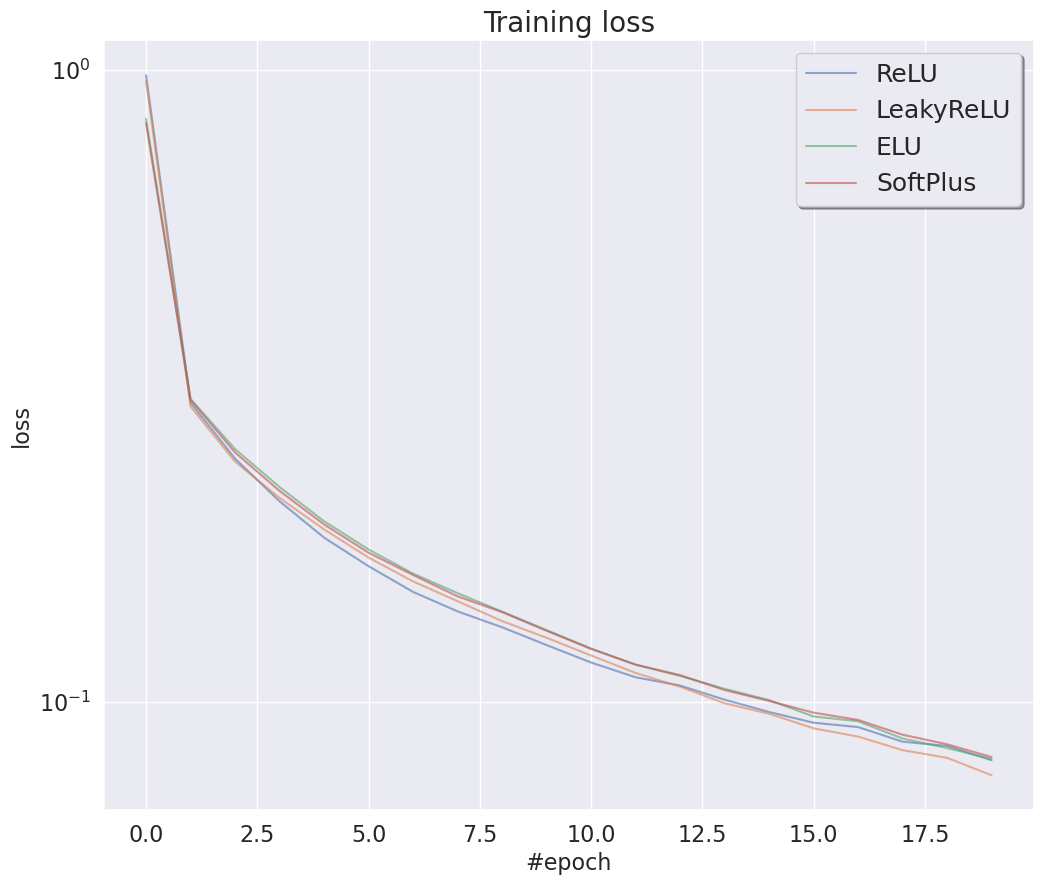

In [35]:
nets = [net_ReLU, net_LeakyReLU, net_ELU, net_SoftPlus]
loss_history = [[],[],[],[]]
ave_loss = [[],[],[],[]]
nets_labels = ["ReLU", "LeakyReLU", "ELU", "SoftPlus"]

for j in range(n_epoch):
            
    for net in nets:
        net.train()        
    
    print(f'Epoch {j + 1}/{n_epoch}')
    correct_samples = [0, 0, 0, 0]
    total_samples = [0, 0, 0, 0]
    loss_accum = [0, 0, 0, 0]
    
    n = 0
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        i = 0
        n += 1
        for cur_net in nets:          
            cur_net.zeroGradParameters()

            # Forward
            predictions = cur_net.forward(x_batch)

            loss = criterion.forward(predictions, y_batch)
            loss_accum[i] += loss

            # Backward    
            dp = criterion.backward(predictions, y_batch)
            cur_net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(cur_net.getParameters(), 
                         cur_net.getGradParameters(), 
                         optimizer_config_[i],
                         optimizer_state_[i])      

            loss_history[i].append(loss)
            
            correct_samples[i] += (predictions.argmax(axis=1) == y_batch.argmax(axis=1)).sum()
            total_samples[i] += y_batch.shape[0]
            
            i += 1
    
    for i in range(4):    
        train_accuracy = float(correct_samples[i]) / total_samples[i]
        val_accuracy = compute_accuracy(nets[i], X_val, y_val)
        ave_loss[i].append(loss_accum[i]/n)
        print(f'{nets_labels[i]}:')
        print(f' Loss: {ave_loss[i][-1]}, Train acc: {train_accuracy}, Val acc: {val_accuracy}')
        
    print('-' * 50)

print("\n\n")
print('Test accuracy:')
for i in range(4):
    test_accuracy = compute_accuracy(nets[i], X_test, y_test)
    print(f'  {nets_labels[i]}: {test_accuracy}')

plt.figure(figsize=(12, 10))

for i in range(4):
    plt.plot(ave_loss[i], label=nets_labels[i], alpha=0.6,
             color=sns.color_palette()[i])

plt.xlabel("#epoch", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yscale('log')
plt.title("Training loss", fontsize=20)
plt.legend(shadow=True, fontsize=18, loc='upper right')

plt.show()

Epoch 1/20
SGD:
 Loss: 1.0170062855636737, Train acc: 0.74542, Val acc: 0.911
Adam:
 Loss: 0.411557510358092, Train acc: 0.89058, Val acc: 0.9363
--------------------------------------------------
Epoch 2/20
SGD:
 Loss: 0.2944979633233252, Train acc: 0.91698, Val acc: 0.9346
Adam:
 Loss: 0.18130847893655166, Train acc: 0.94512, Val acc: 0.9505
--------------------------------------------------
Epoch 3/20
SGD:
 Loss: 0.23938808007072584, Train acc: 0.93176, Val acc: 0.9418
Adam:
 Loss: 0.13963302289520174, Train acc: 0.95726, Val acc: 0.9597
--------------------------------------------------
Epoch 4/20
SGD:
 Loss: 0.20903772424357644, Train acc: 0.94066, Val acc: 0.9378
Adam:
 Loss: 0.11948296311895003, Train acc: 0.96332, Val acc: 0.9605
--------------------------------------------------
Epoch 5/20
SGD:
 Loss: 0.18758426458052205, Train acc: 0.94644, Val acc: 0.9437
Adam:
 Loss: 0.10517941367910016, Train acc: 0.96696, Val acc: 0.9572
--------------------------------------------------


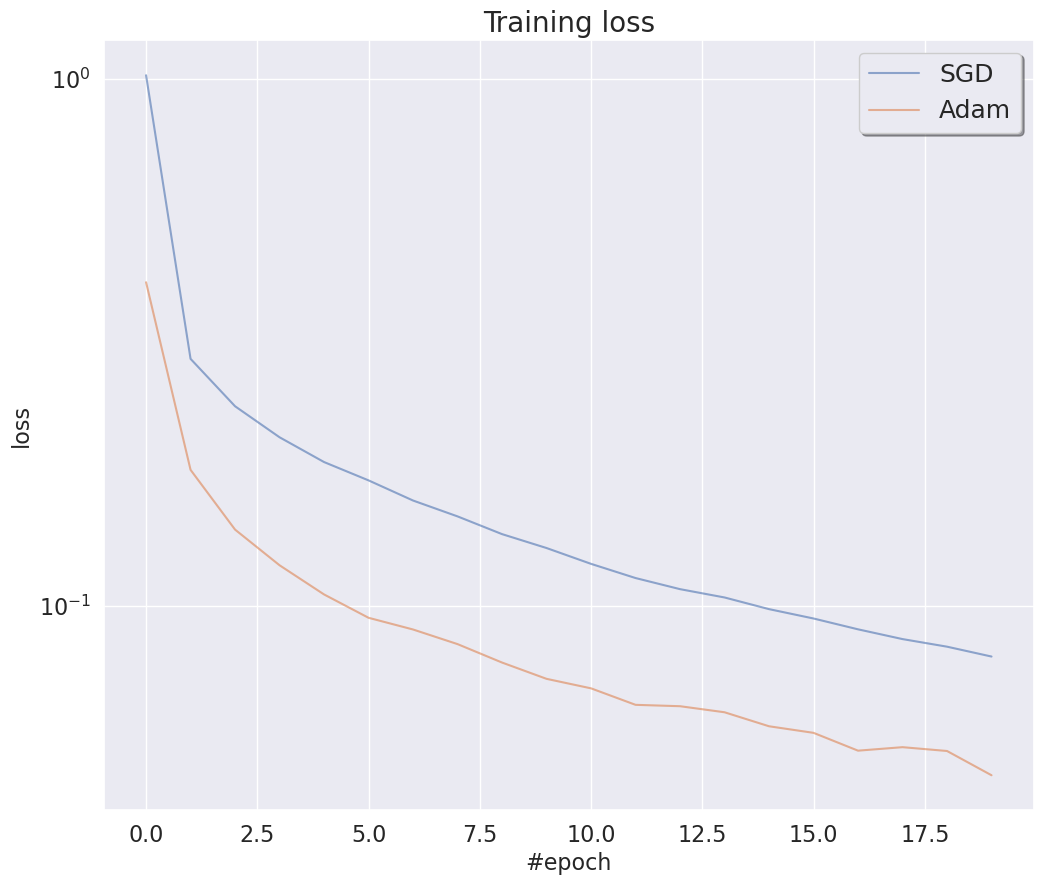

In [36]:
net_SGD = Sequential(modules = [
                    Flatten(),
                    Linear(784, 32),
                    BatchNormalization(),
                    ChannelwiseScaling(32),
                    ReLU(),
                    Linear(32, 10),
                    LogSoftMax()])

net_Adam = Sequential(modules = [
                    Flatten(),
                    Linear(784, 32),
                    BatchNormalization(),
                    ChannelwiseScaling(32),
                    ReLU(),
                    Linear(32, 10),
                    LogSoftMax()])

batch_size = 128
criterion = ClassNLLCriterion()
n_epoch = 20

optimizer_config_ = [{'learning_rate' : 1e-2, 'momentum': 0.9}, 
                     {'learning_rate' : 1e-2, 'beta1': 0.9,
                     'beta2': 0.999, 'epsilon': 1e-8}]
optimizer_state_ = [{},{}]

optimizers = [sgd_momentum, adam_optimizer]


nets = [net_SGD, net_Adam]
loss_history = [[],[]]
ave_loss = [[],[]]
nets_labels = ["SGD", "Adam"]

for j in range(n_epoch):
            
    for net in nets:
        net.train()        
    
    print(f'Epoch {j + 1}/{n_epoch}')
    correct_samples = [0, 0, 0, 0]
    total_samples = [0, 0, 0, 0]
    loss_accum = [0, 0, 0, 0]
    
    n = 0
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        i = 0
        n += 1
        for cur_net in nets:          
            cur_net.zeroGradParameters()

            # Forward
            predictions = cur_net.forward(x_batch)

            loss = criterion.forward(predictions, y_batch)
            loss_accum[i] += loss

            # Backward               
            dp = criterion.backward(predictions, y_batch)
            cur_net.backward(x_batch, dp)

            # Update weights
            optimizers[i](cur_net.getParameters(), 
                         cur_net.getGradParameters(), 
                         optimizer_config_[i],
                         optimizer_state_[i])      

            loss_history[i].append(loss)
            
            correct_samples[i] += (predictions.argmax(axis=1) == y_batch.argmax(axis=1)).sum()
            total_samples[i] += y_batch.shape[0]
            
            i += 1
    
    for i in range(2):    
        train_accuracy = float(correct_samples[i]) / total_samples[i]
        val_accuracy = compute_accuracy(nets[i], X_val, y_val)
        ave_loss[i].append(loss_accum[i]/n)
        print(f'{nets_labels[i]}:')
        print(f' Loss: {ave_loss[i][-1]}, Train acc: {train_accuracy}, Val acc: {val_accuracy}')
        
    print('-' * 50)

print("\n\n")
print('Test accuracy:')
for i in range(2):
    test_accuracy = compute_accuracy(nets[i], X_test, y_test)
    print(f'  {nets_labels[i]}: {test_accuracy}')

plt.figure(figsize=(12, 10))

for i in range(2):
    plt.plot(ave_loss[i], label=nets_labels[i], alpha=0.6,
             color=sns.color_palette()[i])

plt.xlabel("#epoch", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yscale('log')
plt.title("Training loss", fontsize=20)
plt.legend(shadow=True, fontsize=18, loc='upper right')

plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

There's no realistic way to distinguish activation functions on such a simple dataset. Basically, they perform identically. 

BatchNorm definetely helps, but I don't want to check it on mnist, that's kind of boring, honestly, pretty much everything works on that data...

Adam as expected performs noticeably better than SGD, however it does not help with test accuracy due to a minor overfitting.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

![](add_more_layers.png)

Epoch 1/20
 Loss: 0.6110781090406303, Train acc: 0.9068, Val acc: 0.9654
--------------------------------------------------
Epoch 2/20
 Loss: 0.10790297002875711, Train acc: 0.97024, Val acc: 0.9747
--------------------------------------------------
Epoch 3/20
 Loss: 0.07876848436711868, Train acc: 0.97706, Val acc: 0.9726
--------------------------------------------------
Epoch 4/20
 Loss: 0.0652236010211896, Train acc: 0.98164, Val acc: 0.9764
--------------------------------------------------
Epoch 5/20
 Loss: 0.0526852040437519, Train acc: 0.98438, Val acc: 0.9791
--------------------------------------------------
Epoch 6/20
 Loss: 0.04464455484971512, Train acc: 0.9865, Val acc: 0.9722
--------------------------------------------------
Epoch 7/20
 Loss: 0.04188685041166116, Train acc: 0.98702, Val acc: 0.9777
--------------------------------------------------
Epoch 8/20
 Loss: 0.03484074475065065, Train acc: 0.98922, Val acc: 0.9744
------------------------------------------------

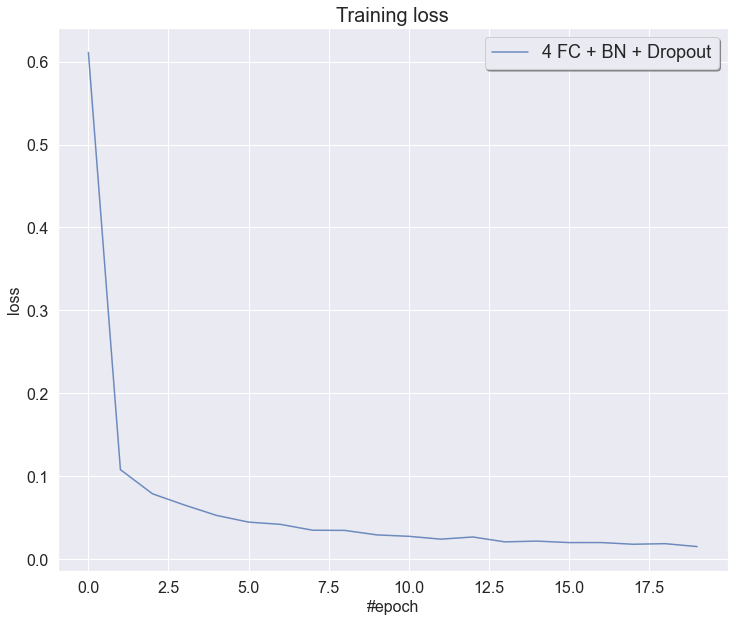

In [51]:
final_net = Sequential(modules = [
                    Flatten(),
                    Linear(784, 784),
                    BatchNormalization(),
                    ChannelwiseScaling(784),
                    ReLU(),
                    Linear(784, 196),
                    BatchNormalization(),
                    ChannelwiseScaling(196),
                    ReLU(),
                    Dropout(p=0.35),
                    Linear(196, 49),
                    BatchNormalization(),
                    ChannelwiseScaling(49),
                    ReLU(),
                    Dropout(p=0.15),
                    Linear(49, 10),
                    LogSoftMax()])

batch_size = 128
criterion = ClassNLLCriterion()
n_epoch = 20

optimizer_config = {'learning_rate' : 2e-3, 'beta1': 0.9,
                     'beta2': 0.99, 'epsilon': 1e-8}
optimizer_state = {}

optimizer = adam_optimizer

loss_history = []
ave_loss = []

for j in range(n_epoch):
            
    final_net.train()       
    
    print(f'Epoch {j + 1}/{n_epoch}')
    correct_samples = 0
    total_samples = 0
    loss_accum = 0
    
    n = 0
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        n += 1       
        final_net.zeroGradParameters()

        # Forward
        predictions = final_net.forward(x_batch)

        loss = criterion.forward(predictions, y_batch)
        loss_accum += loss

        # Backward               
        dp = criterion.backward(predictions, y_batch)
        final_net.backward(x_batch, dp)

        # Update weights
        optimizer(final_net.getParameters(), 
                    final_net.getGradParameters(), 
                    optimizer_config,
                    optimizer_state)      

        loss_history.append(loss)
            
        correct_samples += (predictions.argmax(axis=1) == y_batch.argmax(axis=1)).sum()
        total_samples += y_batch.shape[0]
    
    train_accuracy = float(correct_samples) / total_samples
    val_accuracy = compute_accuracy(final_net, X_val, y_val)
    ave_loss.append(loss_accum/n)
    
    print(f' Loss: {ave_loss[-1]}, Train acc: {train_accuracy}, Val acc: {val_accuracy}')
        
    print('-' * 50)

print("\n\n")
print(f'Test accuracy: {compute_accuracy(final_net, X_test, y_test)}')

plt.figure(figsize=(12, 10))

plt.plot(ave_loss, label="4 FC + BN + Dropout", alpha=0.8,
             color=sns.color_palette()[0])

plt.xlabel("#epoch", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Training loss", fontsize=20)
plt.legend(shadow=True, fontsize=18, loc='upper right')

plt.show()

Print here your accuracy on test set. It should be around 90%.

In [27]:
print(f'Test accuracy: {compute_accuracy(final_net, X_test, y_test)}')

Test accuracy: 0.9778


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

My implementation works well enough to be sure to get similar results copying it to PyTorch, so I'll try to beat it instead using a little more advanced stuff.

In [50]:
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim


model = nn.Sequential(
    nn.Conv2d(1, 16, 5, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 32, 3, padding=0),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.Conv2d(32, 64, 5, padding=0),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Flatten(),
    nn.Linear(8*8*64, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 10)
).cuda()


loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)

optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.9),
                       lr=1e-2, weight_decay=1e-5)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                milestones=[4, 8, 18], gamma=0.2)
#num_epochs = 25
num_epochs = 5

def train_model(model, X_train, y_train, X_val, y_val, loss, optimizer, num_epochs,
                scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        
        n = 0
        for x, y in get_batches((X_train, y_train), batch_size):
            x, y = tensor(x).unsqueeze(1).cuda(), tensor(y).unsqueeze(1).cuda()
            n += 1
            
            prediction = model(x)    
            loss_value = loss(prediction, y.argmax(1))
            optimizer.zero_grad(set_to_none=True)
            loss_value.backward()
            optimizer.step()
            
            indices = torch.argmax(prediction, 1)
            correct_samples += torch.sum(prediction.argmax(1) == y.argmax(1))
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / n
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, X_val, y_val, cuda=True, Torch=True)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(float(val_accuracy))
        
        print(f"Average loss: {ave_loss}, Train accuracy: {train_accuracy}, Val accuracy: {val_accuracy}")
        if scheduler is not None:
            scheduler.step()
        print('-' * 75)
        
    return loss_history, train_history, val_history


loss_history, train_history, val_history = train_model(model, X_train, y_train.argmax(axis=1),
                                            X_val, y_val.argmax(axis=1), loss, optimizer, 
                                                num_epochs, scheduler)

print("\n\n")
print(f'Test accuracy: {compute_accuracy(model, X_test, y_test.argmax(axis=1), cuda=True, Torch=True)}')

Epoch 1/5
Average loss: 0.006932399235665798, Train accuracy: 0.99776, Val accuracy: 1.0
---------------------------------------------------------------------------
Epoch 2/5
Average loss: 9.498923645878676e-06, Train accuracy: 1.0, Val accuracy: 1.0
---------------------------------------------------------------------------
Epoch 3/5
Average loss: 9.498009603703395e-06, Train accuracy: 1.0, Val accuracy: 1.0
---------------------------------------------------------------------------
Epoch 4/5
Average loss: 9.50349658523919e-06, Train accuracy: 1.0, Val accuracy: 1.0
---------------------------------------------------------------------------
Epoch 5/5
Average loss: 9.489166586718056e-06, Train accuracy: 1.0, Val accuracy: 1.0
---------------------------------------------------------------------------



Test accuracy: 1.0


Well, it works, a little overkill though...